### eps을 0.05, min_samples를 5로 설정함

In [23]:
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN
import numpy as np
#훈련 데이터 생성
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

#훈련
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

#첫번째 20개의 레이블 출력 - -1로 분류된 샘플은 이상치
print(dbscan.labels_[:10])


[ 0  2 -1 -1  1  0  0  0  2  5]


In [24]:
#핵심 샘플의 인덱스 개수 확인
print(len(dbscan.core_sample_indices_))

808


In [25]:
#핵심 샘플 자체의 값 출력
print(dbscan.components_)

[[-0.02137124  0.40618608]
 [-0.84192557  0.53058695]
 [ 0.58930337 -0.32137599]
 ...
 [ 1.66258462 -0.3079193 ]
 [-0.94355873  0.3278936 ]
 [ 0.79419406  0.60777171]]


In [26]:
#클러스터 확인
print(np.unique(dbscan.labels_))

[-1  0  1  2  3  4  5  6]


### eps을 0.2, min_samples를 5로 설정함
eps의 값을 크게 하면 이상치를 포함하지 않고, 클러스터의 개수가 줄어듦

In [28]:
dbscan = DBSCAN(eps=0.2, min_samples=5)


dbscan.fit(X)

#첫번째 20개의 레이블 출력 - -1로 분류된 샘플은 이상치
print(dbscan.labels_[:20])

#핵심 샘플의 인덱스 개수 확인
print(len(dbscan.core_sample_indices_))

#핵심 샘플 자체의 값 출력
print(dbscan.components_)

#클러스터 확인
print(np.unique(dbscan.labels_))

[0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1]
1000
[[-0.02137124  0.40618608]
 [ 0.97670045 -0.45832306]
 [ 0.90405882 -0.37651952]
 ...
 [ 1.66258462 -0.3079193 ]
 [-0.94355873  0.3278936 ]
 [ 0.79419406  0.60777171]]
[0 1]


## DBSCAN 군집 결과 시각화

In [41]:
import matplotlib.pyplot as plt
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True

    # 이상치는 반대로 설정
    anormalies_mask = dbscan.labels_ == -1

    # 핵심 포인트도 아니고 이상치도 아닌 이웃 포인트
    non_core_mask = ~(core_mask | anormalies_mask)


    cores = dbscan.components_
    anomalies = X[anormalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)


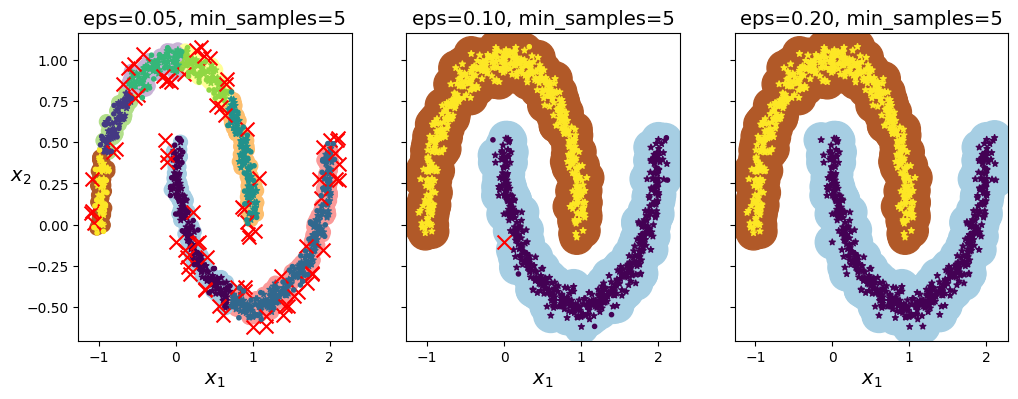

In [46]:
dbscan1 = DBSCAN(eps=0.05)
dbscan1.fit(X)
dbscan2 = DBSCAN(eps=0.1)
dbscan2.fit(X)
dbscan3 = DBSCAN(eps=0.2)
dbscan3.fit(X)
    
plt.figure(figsize=(12, 4))

plt.subplot(131)
plot_dbscan(dbscan1, X, size=100)

plt.subplot(132)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

plt.subplot(133)
plot_dbscan(dbscan3, X, size=600, show_ylabels=False)
plt.show()

In [47]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)
# dbscan.components_: 핵심 샘플 자체의 값
knn.fit(dbscan3.components_, dbscan3.labels_[dbscan3.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

In [48]:
X_new = np.array([[-0.5, 0], [0, 0.5]])
y_hat = knn.predict(X_new)
print(y_hat)

y_hat_proba = knn.predict_proba(X_new)
print(y_hat_proba)

[1 0]
[[0.18 0.82]
 [1.   0.  ]]


## KMeans, GMM, DBSCAN 의 결과 비교
DataFrame 과 클러스터링된 결과를 받아서 시각화하기 위한 함수

In [62]:
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    # 클러스터의 중앙점 찾기
    if iscenter:
        centers = clusterobj.cluster_centers_
    
    unique_labels = np.unique(dataframe[label_name].values)
    markers = ['o', 's', '^', 'x', '*']
    isNoise = False

    # 클러스터 순회
    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name] == label]
        # 이상치
        if label == -1: 
            cluster_legend = 'Noise'
            isNoise = True
        else:
            cluster_legend = 'Cluster ' + str(label)
        
        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'],
                    s=70, edgecolor='k', marker=markers[label],
                    label = cluster_legend)

        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250,
                        color='white', alpha=0.9, edgecolor='k', marker='$%d$' % label)
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70,
                        color='white', edgecolor='k', marker='$%d$' % label)
    if isNoise:
        legend_loc = 'upper center'
    else:
        legend_loc = 'upper right'
    plt.legend(loc=legend_loc)
    plt.show()
        


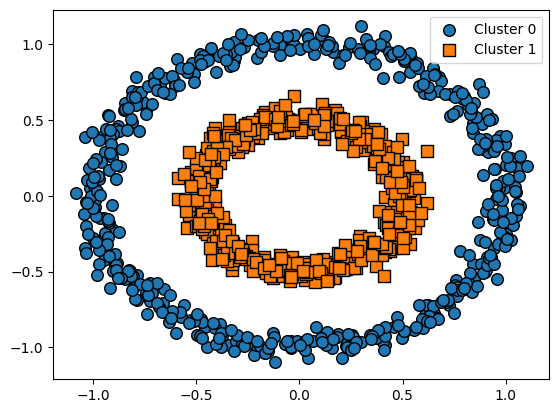

In [67]:
from sklearn.datasets import make_circles
import pandas as pd
X, y = make_circles(n_samples=1000, shuffle=True, noise=0.05, random_state=40,
                    factor=0.5)
clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)


/Users/hyeongihong/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


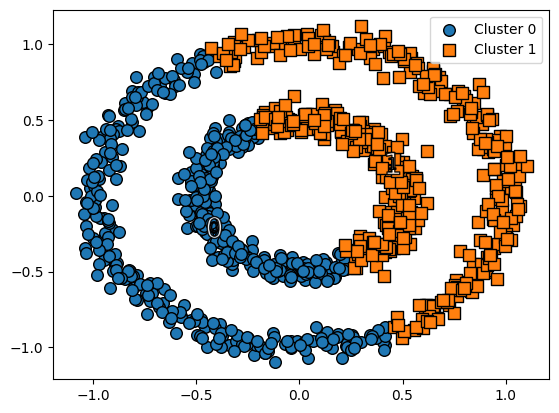

In [68]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, max_iter=1000, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

clusterDF['kmeans_cluster'] = kmeans_labels
visualize_cluster_plot(kmeans, clusterDF, 'kmeans_cluster', iscenter=True)


## GMM 적용

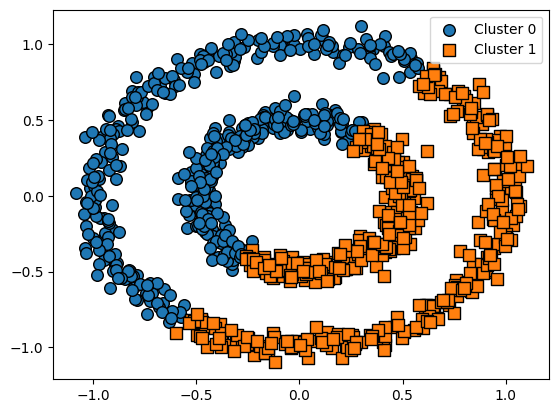

In [71]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state=42)
gmm_label = gmm.fit(X).predict(X)
clusterDF['gmm_cluster'] = gmm_label

visualize_cluster_plot(gmm, clusterDF, 'gmm_cluster', iscenter=False)


## DBSCAN 적용

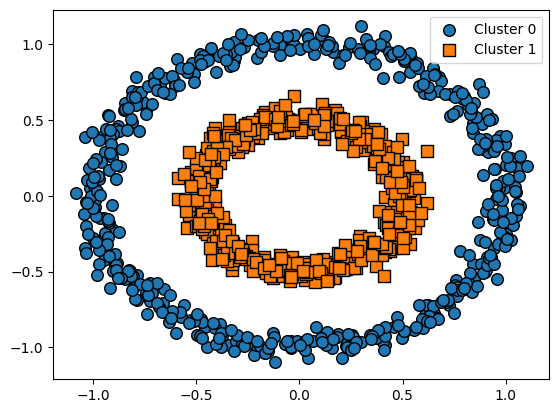

In [73]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps = 0.2, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)

clusterDF['dbscan_cluster'] = dbscan_labels

visualize_cluster_plot(dbscan, clusterDF, 'dbscan_cluster', iscenter=False)